# Test NB for minimum detectable deformation
@author: Max Felius


In [1]:
#imports 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os, time
from tqdm import tqdm
import random
import beepy
from decouple import config
import datetime
import re

In [2]:
def zg(R,r):
    return -np.exp(-np.pi*(r**2/R**2))

In [3]:
#defining the inverse model for case 1 and 2
def case_inverse_kinematic_model(v,t,R,r,y):
    '''
    Non-Linear Least Squares for determining kinematic model parameters
    
    Input:
    :type v: int
    :type t: np.array(float)
    :type R: int
    :type r: np.array(float)
    :type y: np.array(float)
    
    Output
    :rtype R: int
    :rtype v: int
    '''
    #maximum number of runs
    n = 10000
    
    #initial values
    Qyy = np.eye(len(r))
    invQyy = np.linalg.inv(Qyy)
    
    #start the timer
    start = time.time()
    
    for i in range(n):
        #expected deformation
        yhat = v*t*zg(R,r)
        
        #compute the difference in measured and computed subsidence
        dy = y - yhat
        
        #defining the jacobian matrix
        A1 = t*zg(R,r)
        A2 = ((2*v*t*np.pi*r**2)/(R**3))*zg(R,r)
        # A2 = ((2*R**2 + 2*np.pi*r**2)/(R**3))*(v*t)*zg(R,r)
           
        J = np.array([A1,A2]).T
        
        cond_number = np.linalg.cond(J)
        
        Qxhat = np.linalg.inv(J.T @ invQyy @ J)
        dx = Qxhat @ J.T @ invQyy @ dy
        
        v_old = v
        R_old = R
        v = v + dx[0]
        R = R + dx[1]
        
        dx_hat = np.array([v_old-v,R_old-R]).T
        
        if dx_hat.T @ Qxhat @ dx_hat < sys.float_info.epsilon:
#             print(f'Stopped at iteration {i+1}.\nThe computed values are v={v} and R={R}.')
            break
    
#     if i == n-1:
#         print(f'Ended using the maximum number of iterations: {n}.\nThe computed values are v={v} and R={R}.')
#     
#     print(f'The total runtime was: {time.time()-start} seconds.')
    
    ehat = yhat - y
    
    return ehat, y, cond_number, v , R

In [4]:
# #2016
# wink_dir = config('wink2016')
# start_date = '20150421' #2016
# # sinkhole parameters wink 2019
# v_in = 1
# R_in = 500
# x0 = 480 

#2019 -> LOS displacement
wink_dir = config('wink2019')
start_date = '20151016' #2019
#sinkhole parameters wink 2019
v_in = 1
R_in = 500
x0 = 310 

start_date_datetime = datetime.datetime.strptime(start_date,'%Y%m%d')
date_list = []
delta_days = []
data_list = []

for date in sorted(os.listdir(wink_dir)):
    if date.endswith('.csv'):
        #get the date from the title
        m = re.search(r'\d{8}',date)
        date_conv = datetime.datetime.strptime(m.group(0),'%Y%m%d')
        date_list.append(date_conv)

        #Determine the number of days since the start date
        delta_days.append((date_conv-start_date_datetime).days)

        #Read the data from the files
        data_list.append(pd.read_csv(os.path.join(wink_dir,date),header=None))       

In [5]:
r_array = np.array([])
t_array = np.array([])
z_array = np.array([])

fitsave = []
cond_numb_save = []
v_save = []
R_save = []

for i in tqdm(range(len(delta_days)),'Looping'):   
    step = delta_days[i]
    z = data_list[i][1].values
    r = np.sqrt((data_list[i][0].values-x0)**2)
    t_array = np.concatenate((t_array,np.array([step]*len(z))))
    r_array = np.concatenate((r_array,r))
    z_array = np.concatenate((z_array,z))
    
    try:
        ehat, y, cond_number,v_out, R_out = case_inverse_kinematic_model(v_in,t_array,R_in,r_array,z_array)
        fit = 100*(1-(np.sum(abs(ehat))/np.sum(abs(y))))
    except Exception as e:
            print(e, f'at iteration {i}.')
            fit = 0
            cond_number = np.nan
            v_out = np.nan
            R_out = np.nan
            ehat = np.zeros((len(r_array)))

        
    fitsave.append(fit)
    cond_numb_save.append(cond_number)
    v_save.append(v_out)
    R_save.append(R_out)

beepy.beep(sound='coin')

Looping:  21%|██▏       | 3/14 [00:00<00:01,  6.05it/s]

Singular matrix at iteration 0.


Looping: 100%|██████████| 14/14 [00:01<00:00,  8.95it/s]


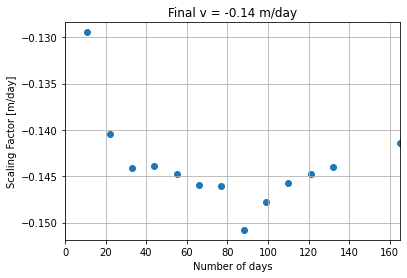

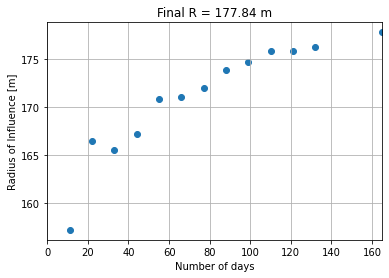

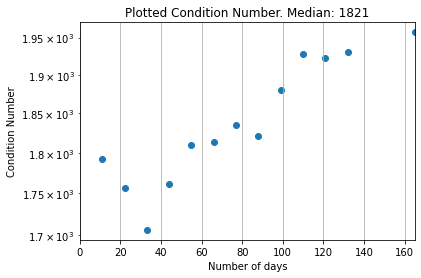

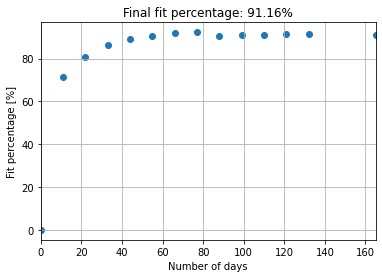

In [6]:
plt.figure()
plt.title('Final v = {:.02f} m/day'.format(v_save[-1]))
plt.scatter(delta_days,v_save)
plt.ylabel('Scaling Factor [m/day]')
plt.xlabel('Number of days')
plt.xlim([0,delta_days[-1]])
plt.grid(True)

plt.figure()
plt.title('Final R = {:.02f} m'.format(R_save[-1]))
plt.scatter(delta_days,R_save)
plt.ylabel('Radius of Influence [m]')
plt.xlabel('Number of days')
plt.xlim([0,delta_days[-1]])
plt.grid(True)

plt.figure()
plt.scatter(delta_days,cond_numb_save)
plt.title('Plotted Condition Number. Median: {:.0f}'.format(np.median(cond_numb_save[1:])))
plt.yscale('log')
plt.ylabel('Condition Number')
plt.xlabel('Number of days')
plt.xlim([0,delta_days[-1]])
plt.grid(True)


plt.figure()
plt.scatter(delta_days,fitsave)
plt.ylabel('Fit percentage [%]')
plt.xlabel('Number of days')
plt.title('Final fit percentage: {:.02f}%'.format(fitsave[-1]))
plt.xlim([0,delta_days[-1]])
plt.grid(True);

In [11]:
n = 15 #days
v_wink2016_gaus = 0.00031316308355901993 #m/day
R_wink2016_gaus = 553.0609564207193 #m
# delta_days_new = np.array([0, 12, 24, 36, 48, 60, 72, 96, 108, 120, 132])
delta_days_new = np.array([12*x for x in range(n)])

samples = 15
r = np.linspace(1,R_wink2016_gaus,samples)

In [12]:
def zg(R,r):
    return np.exp(-np.pi*(r**2/R**2))

def subsidence(r,R_wink2016_gaus,v_wink2016_gaus,step):
    #Subsidence subsamples
    #Setting the noise level, std of 3 mm
    mu = 0 
    sigma = 0.003 #[m]
    noise = np.random.normal(mu, sigma, len(r))
    if step < 48:
        z_subsidence = noise
        print(step,'Noise only')
    else:
        z_subsidence = noise+((step/12)-3)*v_wink2016_gaus*zg(R_wink2016_gaus,r) #[m]
        print(step,'Noise+signal')
    
    return z_subsidence

In [13]:
r_array = np.array([])
t_array = np.array([])
z_array = np.array([])

fitsave = []
cond_numb_save = []
v_save = []
R_save = []

for i in tqdm(range(len(delta_days_new)),'Looping'):   
    step = delta_days_new[i]
    z = subsidence(r,R_wink2016_gaus,v_wink2016_gaus,step)   
    t_array = np.concatenate((t_array,np.array([step]*samples)))
    r_array = np.concatenate((r_array,r))
    z_array = np.concatenate((z_array,z))
    
    try:
        ehat, y, cond_number,v_out, R_out = case_inverse_kinematic_model(1,t_array,500,r_array,z_array)
        fit = 100*(1-(np.sum(abs(ehat))/np.sum(abs(y))))
    except Exception as e:
        print(e, f'at iteration {i}.')
        fit = 0
        cond_number = np.nan
        v_out = np.nan
        R_out = np.nan
        ehat = np.zeros((len(r_array)))
         
    fitsave.append(fit)
    cond_numb_save.append(cond_number)
    v_save.append(v_out)
    R_save.append(R_out)

beepy.beep(sound='coin')

Looping:  20%|██        | 3/15 [00:00<00:00, 25.01it/s]<ipython-input-3-c5d68bad7d65>:53: RuntimeWarning: overflow encountered in matmul
  if dx_hat.T @ Qxhat @ dx_hat < sys.float_info.epsilon:
<ipython-input-3-c5d68bad7d65>:36: RuntimeWarning: overflow encountered in double_scalars
  A2 = ((2*v*t*np.pi*r**2)/(R**3))*zg(R,r)


0 Noise only
Singular matrix at iteration 0.
12 Noise only
24 Noise only
36 Noise only
Singular matrix at iteration 3.
48 Noise+signal
Singular matrix at iteration 4.
60 Noise+signal
Singular matrix at iteration 5.
72 Noise+signal
84 Noise+signal
96 Noise+signal


Looping:  60%|██████    | 9/15 [00:00<00:00, 29.50it/s]

108 Noise+signal


Looping: 100%|██████████| 15/15 [00:04<00:00,  3.15it/s]

120 Noise+signal
132 Noise+signal
144 Noise+signal
156 Noise+signal
168 Noise+signal


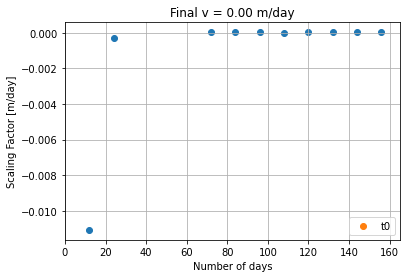

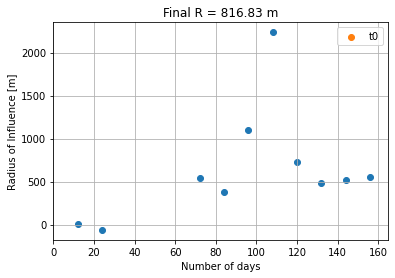

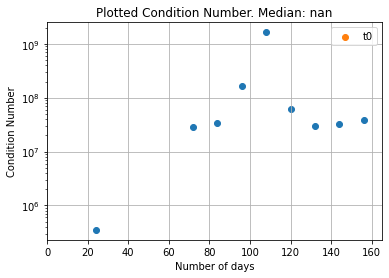

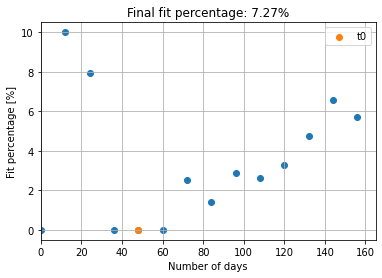

In [15]:
plt.figure()
plt.title('Final v = {:.02f} m/day'.format(v_save[-1]))
plt.scatter(delta_days_new,v_save)
plt.scatter(48,v_save[np.where(delta_days_new==48)[0][0]],label='t0')
plt.ylabel('Scaling Factor [m/day]')
plt.xlabel('Number of days')
plt.xlim([0,delta_days[-1]])
plt.legend()
plt.grid(True)

plt.figure()
plt.title('Final R = {:.02f} m'.format(R_save[-1]))
plt.scatter(delta_days_new,R_save)
plt.scatter(48,R_save[np.where(delta_days_new==48)[0][0]],label='t0')
plt.ylabel('Radius of Influence [m]')
plt.xlabel('Number of days')
plt.xlim([0,delta_days[-1]])
plt.legend()
plt.grid(True)

plt.figure()
plt.scatter(delta_days_new,cond_numb_save)
plt.scatter(48,cond_numb_save[np.where(delta_days_new==48)[0][0]],label='t0')
plt.title('Plotted Condition Number. Median: {:.0f}'.format(np.median(cond_numb_save[1:])))
plt.yscale('log')
plt.ylabel('Condition Number')
plt.xlabel('Number of days')
plt.xlim([0,delta_days[-1]])
plt.legend()
plt.grid(True)


plt.figure()
plt.scatter(delta_days_new,fitsave)
plt.scatter(48,fitsave[np.where(delta_days_new==48)[0][0]],label='t0')
plt.ylabel('Fit percentage [%]')
plt.xlabel('Number of days')
plt.title('Final fit percentage: {:.02f}%'.format(fitsave[-1]))
plt.xlim([0,delta_days[-1]])
plt.legend()
plt.grid(True);